## Prompting bio-image analysis tasks using LangChain
In this notebook we demonstrate how to prompt for executing bio-image analysis tasks using chatGPT and [LangChain](https://github.com/hwchase17/langchain). 

In [1]:
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.tools import tool

from skimage.io import imread
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling

import stackview

For accomplishing this, we need an image storage. To keep it simple, we use a dictionary.

In [2]:
image_storage = {}

To demonstrate bio-image analysis using English language, we define common bio-image analysis functions for loading images, segmenting and counting objects and showing results.

In [3]:
tools = []

In [4]:
@tools.append
@tool
def load_image(filename:str):
    """Useful for loading and image file and storing it."""
    print("loading", filename)
    image = imread(filename)
    image_storage[filename] = image
    return "The image is now stored as " + filename

In [5]:
@tools.append
@tool
def segment_bright_objects(image_name):
    """Useful for segmenting bright objects in an image that has been loaded and stored before."""
    print("segmenting", image_name)
    
    image = image_storage[image_name]
    label_image = voronoi_otsu_labeling(image, spot_sigma=4)
    
    label_image_name = "segmented_" + image_name
    image_storage[label_image_name] = label_image
    
    return "The segmented image has been stored as " + label_image_name

In [6]:
@tools.append
@tool
def show_image(image_name):
    """Useful for showing an image that has been loaded and stored before."""
    print("showing", image_name)
    
    image = image_storage[image_name]
    display(stackview.insight(image))
    
    return "The image " + image_name + " is shown above."

In [7]:
@tools.append
@tool
def count_objects(image_name):
    """Useful for counting objects in a segmented image that has been loaded and stored before."""
    label_image = image_storage[image_name]
    
    num_labels = label_image.max()
    print("counting labels in ", image_name, ":", num_labels)

    return f"The label image {image_name} contains {num_labels} labels."

We create some memory and a large language model based on OpenAI's chatGPT.

In [8]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
llm=ChatOpenAI(temperature=0)

C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


Given the list of tools, the large language model and the memory, we can create an agent.

In [9]:
agent = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION, 
    memory=memory
)

C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


This agent can then respond to prompts.

In [10]:
agent.run("Please load the image data/blobs.tif and show it.")

C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


loading data/blobs.tif


'The image data/blobs.tif has been loaded and stored.'

In [11]:
agent.run("Please segment the image data/blobs.tif .")

segmenting data/blobs.tif


'The segmented image has been stored as segmented_data/blobs.tif'

showing segmented_data/blobs.tif


StackViewNDArray([[0, 0, 0, ..., 4, 4, 4],
                  [0, 0, 0, ..., 4, 4, 4],
                  [0, 0, 0, ..., 4, 4, 4],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
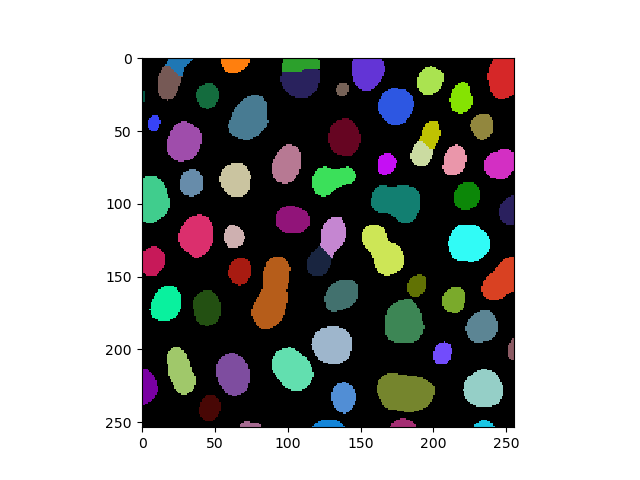

'The image segmented_data/blobs.tif is shown above.'

In [12]:
agent.run("Please show the segmented data/blobs.tif image.")

In [13]:
agent.run("How many objects are there in the segmented data/blobs.tif image?")

counting labels in  segmented_data/blobs.tif : 64


'The segmented data/blobs.tif image contains 64 objects.'

## Chaining operations
We can also chain these operations in a single sentence and the `agent` will figure out on it's own how to do this.

In [14]:
# empty memory and start from scratch
image_memory = {}

In [15]:
agent.run("""
Please load the image data/blobs.tif, 
segment bright objects in it, 
count them and 
show the segmentation result.
""")

'The image data/blobs.tif has been loaded, bright objects have been segmented, there are 64 objects in the segmented image, and the segmentation result has been shown.'

In [16]:
agent.run("How many objects were there?")

'There are 64 objects in the segmented image.'

## Exercise
Add another function that allows to extract quantitative parameters from the segmented objects, e.g. area, and measures the average area of objects.